In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import glob
import math
from skimage.feature import corner_harris,corner_peaks
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
%matplotlib qt
%matplotlib inline



## Perform camera calibration 


In [8]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()


## Image preprocessing and filtering

In [9]:
#Methods
 
    
def undistortion(img): 
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def HLS_filter(image):
    HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = HLS[:,:,0]
    L = HLS[:,:,1]
    S = HLS[:,:,2]
    thresh = (70, 255)
    binary_S = np.zeros_like(S)
    binary_S[(S > thresh[0]) & (S <= thresh[1])] = 1
    imshape = image.shape
        #vertices = np.array([[(80,imshape[0]),(400, 330), (580, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(160,imshape[0]),(imshape[1]/2-60, imshape[0]/2+90),
                  (imshape[1]/2+100, imshape[0]/2+90), (imshape[1]-20,imshape[0])]], dtype=np.int32)
    binary_S= region_of_interest(binary_S, vertices)
    return binary_S
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
def sobel_with_s(image):
    ksize=3
    imshape = image.shape
        #vertices = np.array([[(80,imshape[0]),(400, 330), (580, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(160,imshape[0]),(imshape[1]/2-60, imshape[0]/2+90),
                  (imshape[1]/2+100, imshape[0]/2+90), (imshape[1]-20,imshape[0])]], dtype=np.int32)
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 100))
    gradx = region_of_interest(gradx, vertices)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 100))
    grady = region_of_interest(grady, vertices)
    return gradx

def transform(img):
    imshape = img.shape
    img_size = (img.shape[1], img.shape[0])
    src=np.float32([[160,imshape[0]],[imshape[1]/2-60, imshape[0]/2+90],[imshape[1]/2+100, imshape[0]/2+90], [imshape[1]-20,imshape[0]]])
    dst=np.float32([[(240,imshape[0]),(240, 0),(imshape[1]-130, 0), (imshape[1]-130,imshape[0])]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    wraped =  cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_LINEAR)
    return  Minv, wraped

'''
def lane_centers(h):
    # h is a histogram of lane pixels
    # find the left and right max, which we return
    # as lane centers
    midpoint = np.int(h.shape[0]/2)
    mark_left = np.argmax(h[0:midpoint])
    mark_right = np.argmax(h[midpoint:])+midpoint
    return mark_left, mark_right

def copy_sliding_y_window(src, dst, mid, win_size=80):
    # src contains pixels of potential lane markers
    # dst is an empty image that will receive candidate pixels
    # by sliding a window from "mid"-point, the vertical y coordinate
    # for a potential lane marker.
    for row in range(src.shape[0]-1,0,-1):
        lo = max(0,mid-win_size)
        hi = min(mid+win_size, src.shape[1]-1)
        scan_line = src[row,lo:hi]
        dst[row,lo:hi] = scan_line
        ones = np.where(scan_line == 1)
        if len(ones[0]):
            mid = np.int(np.mean(ones)+lo+0.5)
'''
#ml, mr = lane_centers(histogram)
#lines = np.zeros_like(bw_img)
#copy_sliding_y_window(bw_img, lines, ml)
#copy_sliding_y_window(bw_img, lines, mr)
#plt.axis('off')
#plt.imshow(lines, cmap='gray')
 
###

def poly_fit(Minv,warped_img,image):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    row_w,col_w=warped_img.shape
    warped_img_left=warped_img[0:row_w,0:math.ceil(col_w/2)]
    warped_img_right=warped_img[0:row_w,math.ceil(col_w/2):col_w]
    corners_left = corner_peaks(corner_harris(warped_img_left),min_distance=2)
    corners_right = corner_peaks(corner_harris(warped_img_right),min_distance=2)
    y_corner_l,x_corner_l = zip(*corners_left)
    adjusted_corners_right= corners_right+[0,math.ceil(col_w/2)]
    y_corner_r,x_corner_r = zip(*adjusted_corners_right)
    yvalus = warped_img.shape[0]
    yvals = np.linspace(0, 100, num=101)*(yvalus/100.0)  # to cover same y-range as image
    leftx = np.array(x_corner_l)
    lefty = np.array(y_corner_l)
    rightx = np.array(x_corner_r)
    righty = np.array(y_corner_r)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    ####
#extrapolate to fit the line in top and bottom
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
########
    
    
    #plt.plot(leftx, lefty, 'o', color='red')
    #plt.plot(rightx, righty, 'o', color='blue')
    #plt.xlim(0, 1280)
    #plt.ylim(0, 720)
    #plt.plot(left_fitx, lefty, color='green', linewidth=3)
    #plt.plot(right_fitx, righty, color='green', linewidth=3)
    #plt.gca().invert_yaxis() # to visualize as we do the images
    y_eval_l = np.max(lefty)
    y_eval_r = np.max(righty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval_l + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval_r + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_l + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_r + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
    #print(left_curverad, 'm', right_curverad, 'm')
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, lefty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, righty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    final_result=cv2.putText(result, "Left:{}".format(left_curverad),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
    final_result=cv2.putText(result, "Right:{}".format(right_curverad),(10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
    plt.imshow(final_result)
    return final_result

## Perspective transform

 

In [10]:
def pipe_line(image):
    
    image = undistortion(image)
    image = gaussian_noise(image, kernel_size=1)
    binary_s = HLS_filter(image)
    Sobel_x = sobel_with_s(image)
    Sobel_binary_S = np.zeros_like(Sobel_x)
    Sobel_binary_S[(binary_s== 1) | (Sobel_x== 1)] = 1
    ####
    #fig = plt.figure()
    #plt.imshow(Sobel_binary_S,cmap='gray')
    ####
    Minv, warped_img= transform(Sobel_binary_S)
    
    ####
    #warped_histogram = np.sum(warped_img[np.int(warped_img.shape[0]*0.6):,:], axis=0)
    #ml, mr = lane_centers(warped_histogram)
    #lines = np.zeros_like(warped_img)
    #copy_sliding_y_window(warped_img, lines, ml)
    #copy_sliding_y_window(warped_img, lines, mr)
    #final_img = poly_fit(Minv,warped_img,image)
    
    ####
    final_img = poly_fit(Minv,warped_img,image)
    return final_img
 

array([[[199, 159, 117],
        [199, 159, 117],
        [199, 159, 117],
        ..., 
        [186, 140,  82],
        [186, 140,  82],
        [187, 140,  84]],

       [[199, 159, 117],
        [199, 159, 117],
        [199, 159, 117],
        ..., 
        [186, 140,  82],
        [186, 140,  82],
        [186, 139,  83]],

       [[198, 158, 116],
        [199, 159, 117],
        [199, 159, 117],
        ..., 
        [186, 140,  82],
        [186, 140,  82],
        [185, 138,  82]],

       ..., 
       [[101,  87, 102],
        [101,  87, 102],
        [101,  87, 102],
        ..., 
        [ 91,  92, 113],
        [ 89,  92, 113],
        [ 89,  91, 112]],

       [[100,  87, 104],
        [101,  88, 104],
        [102,  89, 105],
        ..., 
        [ 90,  91, 112],
        [ 90,  93, 114],
        [ 91,  94, 115]],

       [[102,  90, 108],
        [102,  90, 108],
        [102,  90, 108],
        ..., 
        [ 88,  91, 113],
        [ 91,  94, 116],
        [ 93,  96,

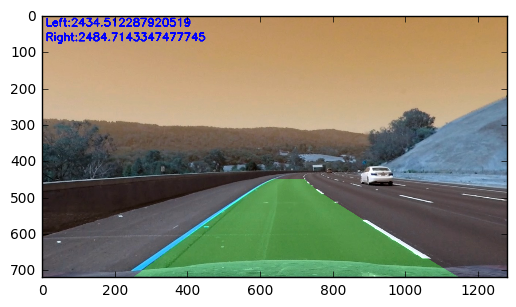

In [11]:
img = cv2.imread('test_images/Distorted/test3.jpg')
pipe_line(img)

In [6]:
'''
white_output = 'output_easy.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipe_line) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-6-c3210af4091e>, line 5)

In [10]:
'''

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-10-a80e1ac67ba4>, line 7)

In [ ]:
white_output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipe_line) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


 99%|█████████▊| 1184/1200 [32:01<00:25,  1.62s/it]    | 1/1200 [00:01<31:36,  1.58s/it]

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))